In [645]:
from datetime import datetime
import pickle
import PIL, torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import ndimage

from torchvision import models
from torch import nn
import pandas as pd

from load_data import load_et_maps, load_images, load_labels, classes
from load_models import load_mobilenet, load_resnet
from utils import batch_accuracy, get_targets

if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)
dtype = torch.float32

OCC_ONLY = Path('/home/florian/dev/ET-Adversarials/data/Occ_only_226px/')
IMGS = Path('/home/florian/dev/ET-Adversarials/data/scaled_images/')

#torch.cuda.set_per_process_memory_fraction(.5,0)

cuda:0


# Load Data and Model

In [646]:
img_batch = load_images(IMGS).to(device)
etm_batch = load_et_maps(OCC_ONLY).to(device)
labels = load_labels(IMGS).to(device)

In [647]:
MOBILENET_PATH = './models/MobileNetV3Small.pt'
model = load_mobilenet(MOBILENET_PATH).to(device)
batch_accuracy(model, img_batch, labels)

1.0

In [5]:
!pip install grad-cam

     |████████████████████████████████| 1.8 MB 4.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 60.3 MB 118.7 MB/s eta 0:00:01
  Created wheel for grad-cam: filename=grad_cam-1.3.6-py3-none-any.whl size=20115 sha256=0ddd306fded34f05b731405995b8b2cce82d87f6fc6280193175b96c3a7226cb
  Stored in directory: /home/florian/.cache/pip/wheels/0f/9d/bd/f68de20b28c1db6d66c0d2fc8e11e056b641abc6733871803b
Successfully built grad-cam


In [6]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [81]:
target_layers = [list(model.modules())[-9]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [389]:
img = img_batch[0].detach().cpu()
hm = cam(input_tensor=img_batch[:1])

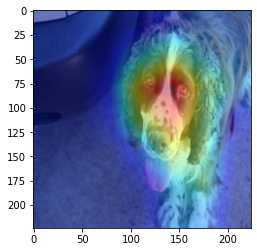

In [390]:
plt.imshow(img_batch[0].detach().cpu().permute(1,2,0))
plt.imshow(hm.transpose(1,2,0), cmap='jet', alpha=0.4)

In [454]:
threshold = np.quantile(hm.flatten(), .85)
b_mask = np.where(hm>threshold, np.ones_like(hm), np.zeros_like(hm))

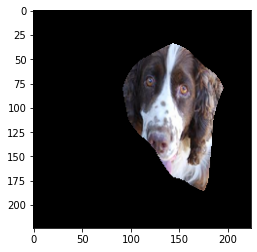

In [450]:
plt.imshow((b_mask*img_batch[0].detach().cpu().numpy()).transpose(1,2,0))


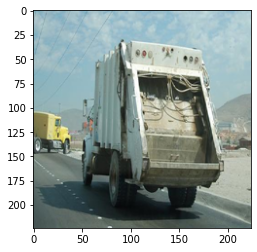

In [393]:
plt.imshow(img_batch[2].detach().cpu().permute(1,2,0))

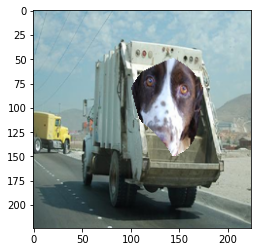

In [394]:
plt.imshow(np.where(b_mask==True, img_batch[0].detach().cpu().numpy(), img_batch[2].detach().cpu().numpy()).transpose(1,2,0))

In [395]:
invariance_based_adv = torch.Tensor(np.where(b_mask==True, img_batch[0].detach().cpu().numpy(), img_batch[2].detach().cpu().numpy()))

In [396]:
c_o_m = ndimage.measurements.center_of_mass(b_mask);c_o_m

(0.0, 95.42487046632124, 140.15922678357913)

In [397]:
i = 12
a_img = img_batch[i:i+1].detach().cpu()
a_hm = cam(input_tensor=a_img)

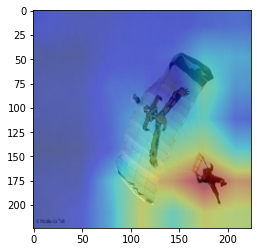

In [398]:
plt.imshow(a_img[0].detach().cpu().permute(1,2,0))
plt.imshow(a_hm.transpose(1,2,0), cmap='jet', alpha=0.4)

In [399]:
a_threshold = np.quantile(hm1.flatten(), .90)
a_b_mask = np.where(a_hm>=a_threshold, np.ones_like(a_hm), np.zeros_like(a_hm))

5018


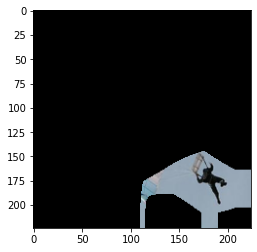

In [400]:
plt.imshow((a_b_mask*a_img[0].detach().cpu().numpy()).transpose(1,2,0))
print(np.count_nonzero(a_b_mask))

In [401]:
a_c_o_m = ndimage.measurements.center_of_mass(a_b_mask); c_o_m1

(0.0, 181.1584296532483, 172.39916301315264)

In [402]:
offset = np.array(c_o_m) - np.array(c_o_m1);offset[1:]

array([-85.73355919, -32.23993623])

In [421]:
img_to_copy = np.pad(a_img[0,:,86:,32:].numpy(), (((0,0),(0,86),(0,32))))

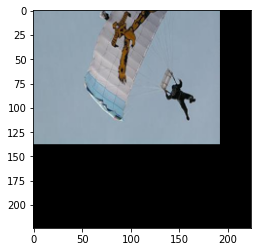

In [455]:
plt.imshow(img_to_copy.transpose(1,2,0))

In [456]:
invariance_adv = np.where(b_mask==True, img_to_copy, img).transpose(1,2,0)

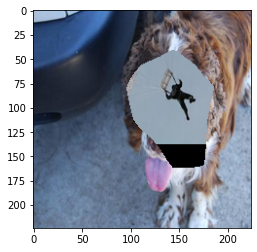

In [457]:
plt.imshow(invariance_adv)

In [458]:
model(torch.Tensor(invariance_adv).permute(2,1,0).unsqueeze(0).cuda()).argmax(-1)

tensor([1], device='cuda:0')

In [459]:
model(a_img.cuda()).argmax(-1)

tensor([9], device='cuda:0')

In [460]:
model(img.unsqueeze(0).cuda()).argmax(-1)

tensor([1], device='cuda:0')

In [417]:
a = np.array([[[2,2],[2,2]]]);a

array([[[2, 2],
        [2, 2]]])

In [420]:
np.pad(a, (((0,0),(0,2),(0,2))))

array([[[2, 2, 0, 0],
        [2, 2, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]])

In [798]:
def create_invariance_based_adversarial_example(base_image, attack_image, initial_ratio):
    '''
    base_image: 3d torch.Tensor
    attack_image: 3d torch.Tensor
    returns the invariance based adversarial example and a tensor with the predictions of the base image, the attack iamge and the adversarial example
    '''
    target_layers = [list(model.modules())[-9]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    
    img = base_image.detach().cpu()
    hm = cam(input_tensor=base_image.unsqueeze(0))
    attack_hm = cam(input_tensor=attack_image.unsqueeze(0))
    best_adv = np.array((224,224,3))
    #print(np.flip(np.arange(1,0,.01)))
    for ratio in np.flip(np.linspace(0,1,101)):
        #print(ratio)
        threshold = np.quantile(hm.flatten(), ratio)
        b_mask = np.where(hm>threshold, np.ones_like(hm), np.zeros_like(hm))
        base_c_o_m = ndimage.measurements.center_of_mass(b_mask)

        
        attack_threshold = np.quantile(attack_hm.flatten(), ratio)
        attack_b_mask = np.where(attack_hm>=attack_threshold, np.ones_like(a_hm), np.zeros_like(a_hm))
        attack_c_o_m = ndimage.measurements.center_of_mass(attack_b_mask)


        #to copy the important part of the attack image to the desired location in the base image, 
        #we calculate the offset of the center of mass of the respective binary maps derived from the gradcam map
        #we then pad and slice the attack image in such a way that the locations of interest in the base and attack images 
        #finally overlap
        _, offset_horizontal, offset_vertical = np.array(base_c_o_m) - np.array(attack_c_o_m)
        padding = np.array([
            np.maximum(offset_horizontal, 0), 
            np.maximum(offset_vertical,0), 
            np.abs(np.minimum(offset_horizontal, 0)), 
            np.abs(np.minimum(offset_vertical,0))
        ]).astype(np.int16)

        slicing = np.array([np.abs(np.minimum(offset_horizontal, 0)), np.abs(np.minimum(offset_vertical,0)), np.maximum(offset_horizontal, 0), np.maximum(offset_vertical,0)]).astype(np.int16)
        sliced_img = attack_image[:,slicing[0]:224-slicing[2], slicing[1]:224-slicing[3]]
        padded_img = np.pad(sliced_img.numpy(), ((0,0),(padding[0],padding[2]),(padding[1], padding[3])))
        invariance_adv = np.where(b_mask==True, padded_img, base_image).transpose(1,2,0)
        preds = model(torch.stack((base_image, attack_image,torch.Tensor(invariance_adv).permute(2,0,1) )).cuda()).argmax(-1)
        if preds[0] != preds[2]:
            break
        else:
            best_adv = invariance_adv
    preds = model(torch.stack((base_image, attack_image,torch.Tensor(best_adv).permute(2,0,1) )).cuda()).argmax(-1)
    #print(preds)
    #print('*****--------*******')
    return best_adv, preds, (attack_hm, hm)

In [ ]:
for i in range(60,100):
    base_image = img_batch[i].cpu()
    #fix, axes = plt.subplots(20,5, figsize=(20,200))
    Path('./inv-based-advs/base-'+str(i)).mkdir(parents=True, exist_ok=True)
    print(i)
    for j,ax in enumerate(axes.flatten()):
        attack_image = img_batch[j].cpu()
        preds = model(torch.stack((base_image,attack_image)).to(device)).argmax(-1)
        
        if preds[0] != preds[1]:
            adv, preds, (attack_hm, base_hm) = create_invariance_based_adversarial_example(base_image, attack_image, .85)
            #ax.imshow(adv)
            #ax.set_title('Prediction: '+str(preds[2].item()))
            plt.imshow(adv)
        else:
            #ax.imshow(attack_image.permute(1,2,0))
            plt.imshow(attack_image.permute(1,2,0))
        plt.savefig('./inv-based-advs/base-'+str(i)+'/attack-'+str(j))



60
61
62
63
64
65
66


[]
0.99
-57.221115537848604 129.503984063745
129.503984063745
[  0 129  57   0]
[  0 129  57   0]
[ 57   0   0 129]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.98
-71.13047808764941 102.17729083665338
102.17729083665338
[  0 102  71   0]
[  0 102  71   0]
[ 71   0   0 102]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.97
-78.9621513944223 86.23306772908367
86.23306772908367
[ 0 86 78  0]
[ 0 86 78  0]
[78  0  0 86]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.96
-82.53361988022003 76.71507343818547
76.71507343818547
[ 0 76 82  0]
[ 0 76 82  0]
[82  0  0 76]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.9500000000000001
-84.88601036269431 70.4045436428856
70.4045436428856
[ 0 70 84  0]
[ 0 70 84  0]
[84  0  0 70]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.9400000000000001
-86.14978412487545 66.05413483892393
66.05413483892393
[ 0 66 86  0]
[ 0 66 86  0]
[86  0  0 66]
(1, 224, 224) (3, 224, 224) torch.Size([3, 224, 224])
0.93
-86.33

Text(0.5, 1.0, 'Base heatmap')

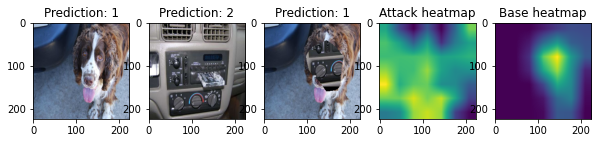

In [725]:
base_image = img_batch[0].cpu()
attack_image = img_batch[14].cpu()
adv, preds, (attack_hm, base_hm) = create_invariance_based_adversarial_example(base_image, attack_image, .85)

fix, axes = plt.subplots(1,5, figsize=(10,10))
axes = axes.flatten()
axes[0].imshow(base_image.permute(1,2,0))
axes[0].set_title('Prediction: '+str(preds[0].item()))
axes[1].imshow(attack_image.permute(1,2,0))
axes[1].set_title('Prediction: '+str(preds[1].item()))
axes[2].imshow(adv)
axes[2].set_title('Prediction: '+str(preds[2].item()))

axes[3].imshow(attack_hm.transpose(1,2,0))
axes[3].set_title('Attack heatmap')

axes[4].imshow(base_hm.transpose(1,2,0))
axes[4].set_title('Base heatmap')


In [698]:
base_image = img_batch[0].cpu()
attack_image = img_batch[14].cpu()
adv, preds = create_invariance_based_adversarial_example(base_image, attack_image, .85)

fix, axes = plt.subplots(1,3)
axes = axes.flatten()
axes[0].imshow(base_image.permute(1,2,0))
axes[0].set_title('Prediction: '+str(preds[0].item()))
axes[1].imshow(attack_image.permute(1,2,0))
axes[1].set_title('Prediction: '+str(preds[1].item()))
axes[2].imshow(adv)
axes[2].set_title('Prediction: '+str(preds[2].item()))


[]
0.99
[   0 -127   57    0]


ValueError: index can't contain negative values

In [659]:

ndimage.gaussian_filter(attack_hm, 1)

array([[[0.54680896, 0.54680896, 0.54680896, ..., 0.16274513,
         0.16274513, 0.16274513],
        [0.54680896, 0.54680896, 0.54680896, ..., 0.16274513,
         0.16274513, 0.16274513],
        [0.54680896, 0.54680896, 0.54680896, ..., 0.16274513,
         0.16274513, 0.16274513],
        ...,
        [0.9875252 , 0.9875252 , 0.9875252 , ..., 0.2015774 ,
         0.2015774 , 0.2015774 ],
        [0.9875252 , 0.9875252 , 0.9875252 , ..., 0.2015774 ,
         0.2015774 , 0.2015774 ],
        [0.9875252 , 0.9875252 , 0.9875252 , ..., 0.2015774 ,
         0.2015774 , 0.2015774 ]]], dtype=float32)

Text(0.5, 1.0, 'sigma: 20')

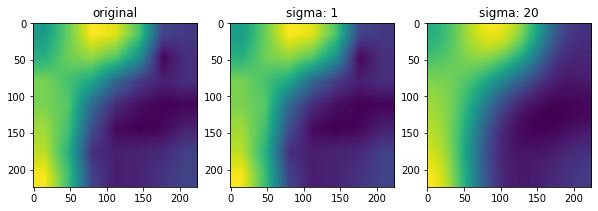

In [680]:
fix, axes = plt.subplots(1,3, figsize=(10,10))
axes = axes.flatten()
axes[0].imshow(attack_hm.transpose(1,2,0))
axes[0].set_title('original')
axes[1].imshow(ndimage.gaussian_filter(attack_hm, 1).transpose(1,2,0))
axes[1].set_title('sigma: 1')
axes[2].imshow(ndimage.gaussian_filter(attack_hm, 20).transpose(1,2,0))
axes[2].set_title('sigma: 20')
